### Installing MediaPipe

In [ ]:
%%capture
!pip install mediapipe

### Required Libraries

In [ ]:
import numpy as np
import os,cv2,math,glob,random
import scipy.io as sio
from math import cos, sin
from pathlib import Path
import pandas as pd
import mediapipe
import warnings
from urllib.request import urlopen
import imageio

warnings.filterwarnings('ignore')
from google.colab.patches import cv2_imshow

# if working on google colab
# from google.colab import drive
# drive.mount('/content/drive') 

Mounted at /content/drive


### Dowlining Data

In [ ]:
# link of the data
# http://www.cbsr.ia.ac.cn/users/xiangyuzhu/projects/3DDFA/Database/AFLW2000-3D.zip

# to download the data uncomment this line
#!wget http://www.cbsr.ia.ac.cn/users/xiangyuzhu/projects/3DDFA/Database/AFLW2000-3D.zip

In [ ]:
# %%capture
# !unzip '/content/drive/MyDrive/Colab Notebooks/ML1/Project/AFLW2000-3D.zip'

In [ ]:
# Function to draw the 3 pose lines
def draw_axis(img, pitch,yaw,roll, tdx=None, tdy=None, size = 100):

    yaw = -yaw
    if tdx != None and tdy != None:
        tdx = tdx
        tdy = tdy
    else:
        height, width = img.shape[:2]
        tdx = width / 2
        tdy = height / 2

    # X-Axis pointing to right. drawn in red
    x1 = size * (cos(yaw) * cos(roll)) + tdx
    y1 = size * (cos(pitch) * sin(roll) + cos(roll) * sin(pitch) * sin(yaw)) + tdy

    # Y-Axis | drawn in green
    #        v
    x2 = size * (-cos(yaw) * sin(roll)) + tdx
    y2 = size * (cos(pitch) * cos(roll) - sin(pitch) * sin(yaw) * sin(roll)) + tdy

    # Z-Axis (out of the screen) drawn in blue
    x3 = size * (sin(yaw)) + tdx
    y3 = size * (-cos(yaw) * sin(pitch)) + tdy

    cv2.line(img, (int(tdx), int(tdy)), (int(x1),int(y1)),(0,0,255),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x2),int(y2)),(0,255,0),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x3),int(y3)),(255,0,0),2)

    return img

### Preparing Data

In [ ]:
all_images = glob.glob('AFLW2000/*.jpg')

In [ ]:
%%time
valid_images = []
features_x, features_y = [],[]
label_data = []
for image in all_images:
    img = cv2.imread(image)
    faceModule = mediapipe.solutions.face_mesh
    with faceModule.FaceMesh(static_image_mode=True) as faces:
        results = faces.process(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        if results.multi_face_landmarks != None:
            # Getting labels
            mat_data = sio.loadmat(image[:-3]+'mat')
            label_data.append(mat_data['Pose_Para'][0][:3])
            # Getting features 
            valid_images.append(image)
            for face in results.multi_face_landmarks:
                face_xs, face_ys = [],[]
                for i, landmark in enumerate(face.landmark):
                    x,y = landmark.x, landmark.y
                    face_xs.append(x)
                    face_ys.append(y)
                features_x.append(face_xs)
                features_y.append(face_ys)  


features_x = np.array(features_x)
features_y = np.array(features_y)
# differencing the points from point 0
x_center = features_x - features_x[:,0].reshape(-1,1)
y_center = features_y - features_y[:,0].reshape(-1,1)
features_data = np.hstack([x_center,y_center])

label_data = np.array(label_data)

CPU times: user 1min 26s, sys: 7.95 s, total: 1min 34s
Wall time: 1min 23s


In [ ]:
from sklearn.linear_model import Lasso,Ridge
from sklearn.svm import SVR
from xgboost import XGBRegressor

from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import PCA

# Trying different models


In [ ]:
def eval_model(model, X,y,scoring='neg_mean_squared_error'):
    print(model.__class__.__name__.center(50,'-'))

    model = Pipeline([('normalizer', Normalizer()),
                  ('scaler', PCA(n_components=0.9995)),
                  ('model',model)])
    
    score = cross_validate(model, X, y, cv=5, scoring='neg_mean_squared_error')
    print('Average MSE = ', -score['test_score'].mean())
    print('='.center(70,'='))

def test_all_models(x,y):
    eval_model(SVR(), x,y,scoring='neg_mean_squared_error')
    eval_model(XGBRegressor(objective='reg:squarederror'), x,y,scoring='neg_mean_squared_error')
    eval_model(Lasso(), x,y,scoring='neg_mean_squared_error')
    eval_model(Ridge(), x,y,scoring='neg_mean_squared_error')


y_pitch= label_data[:,0]
y_yaw= label_data[:,1]
y_roll= label_data[:,2]

In [ ]:
test_all_models(features_data, y_pitch)

-----------------------SVR------------------------
Average MSE =  0.2499638536884557
-------------------XGBRegressor-------------------
Average MSE =  0.28726853857280565
----------------------Lasso-----------------------
Average MSE =  0.3020288886946214
----------------------Ridge-----------------------
Average MSE =  0.2653807844895899


In [ ]:
test_all_models(features_data, y_yaw)

-----------------------SVR------------------------
Average MSE =  0.04478728404973088
-------------------XGBRegressor-------------------
Average MSE =  0.06972694094964625
----------------------Lasso-----------------------
Average MSE =  0.33681727586211424
----------------------Ridge-----------------------
Average MSE =  0.05028374764489919


In [ ]:
test_all_models(features_data, y_roll)

-----------------------SVR------------------------
Average MSE =  0.29207001076939154
-------------------XGBRegressor-------------------
Average MSE =  0.32681041478931805
----------------------Lasso-----------------------
Average MSE =  0.4215883660524561
----------------------Ridge-----------------------
Average MSE =  0.3095250110168166


# Hyper Parameter Tuning


**Choosing SVR as it looks like the best model then will try to tweak it's hyperparameters**

In [ ]:
preprocessor =  Pipeline([('normalizer', Normalizer()),
                  ('scaler', PCA(n_components=0.9995))])

X_features = preprocessor.fit_transform(features_data)

y_train_pitch= label_data[:,0]
y_train_yaw= label_data[:,1]
y_train_roll= label_data[:,2]


In [ ]:
%%time
# Pitch
svr_pitch =SVR()
print('Training with default params')
score = cross_validate(svr_pitch, features_data, y_pitch, cv=5, scoring='neg_mean_squared_error')
print('Average MSE = ', -score['test_score'].mean())


param_grid = {'C': [0.1, 1, 10, 100],
              'gamma': [1, 0.1, 0.01],
              'kernel': ['rbf']}
              
# grid search pitch
svr_pitch = SVR()

Gridcv_pitch = GridSearchCV(estimator = svr_pitch, param_grid = param_grid, scoring='neg_mean_squared_error', verbose=1).fit(features_data, y_pitch)

print('Best Parameters = ',Gridcv_pitch.best_params_)

# Pitch
svr_pitch = SVR(**Gridcv_pitch.best_params_)
print('Training model with best parameters')
score = cross_validate(svr_pitch, features_data, y_pitch, cv=5, scoring='neg_mean_squared_error')
print('Average MSE = ', -score['test_score'].mean())

Training with default params
Average MSE =  0.2481292915620316
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Parameters =  {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
Training model with best parameters
Average MSE =  0.24573288360716772
CPU times: user 37.6 s, sys: 81.8 ms, total: 37.7 s
Wall time: 37.8 s


In [ ]:
%%time
# Yaw
print('Training with default params')
score = cross_validate(SVR(), features_data, y_yaw, cv=5, scoring='neg_mean_squared_error')
print('Average MSE = ', -score['test_score'].mean())


param_grid = {'C': [0.1, 1, 10, 100],
              'gamma': [1, 0.1, 0.01],
              'kernel': ['rbf']}
              
              
# grid search Yaw
Gridcv_yaw = GridSearchCV(estimator = SVR(), param_grid = param_grid, scoring='neg_mean_squared_error', verbose=1).fit(features_data, y_yaw)

print('Best Parameters = ',Gridcv_yaw.best_params_)
print('Training model with best parameters')
score = cross_validate(SVR(**Gridcv_yaw.best_params_),features_data, y_yaw, cv=5, scoring='neg_mean_squared_error')
print('Average MSE = ', -score['test_score'].mean())

Training with default params
Average MSE =  0.04559308723476631
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Parameters =  {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
Training model with best parameters
Average MSE =  0.04316922233264252
CPU times: user 29.3 s, sys: 14.3 ms, total: 29.3 s
Wall time: 29.3 s


In [ ]:
%%time
# Roll
print('Training with default params')
score = cross_validate(SVR(), features_data, y_roll, cv=5, scoring='neg_mean_squared_error')
print('Average MSE = ', -score['test_score'].mean())

param_grid = {'C': [0.1, 1, 10, 100],
              'gamma': [1, 0.1, 0.01],
              'kernel': ['rbf']}
              
# grid search Roll
Gridcv_roll = GridSearchCV(estimator = SVR(), param_grid = param_grid, scoring='neg_mean_squared_error', verbose=1).fit(features_data, y_roll)

print('Best Parameters = ',Gridcv_roll.best_params_)
print('Training model with best parameters')
score = cross_validate(SVR(**Gridcv_roll.best_params_), features_data, y_roll, cv=5, scoring='neg_mean_squared_error')
print('Average MSE = ', -score['test_score'].mean())

Training with default params
Average MSE =  0.2963407047401948
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Parameters =  {'C': 10, 'gamma': 1, 'kernel': 'rbf'}
Training model with best parameters
Average MSE =  0.2691470749273409
CPU times: user 22.6 s, sys: 16.6 ms, total: 22.6 s
Wall time: 22.6 s


# Testing model

In [ ]:
def extract_feature(img):
    """Function to extract features form an img"""
    faceModule = mediapipe.solutions.face_mesh
    with faceModule.FaceMesh(static_image_mode=True) as faces:
        results = faces.process(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        if results.multi_face_landmarks != None:
            # Getting features 
            for face in results.multi_face_landmarks:
                face_xs, face_ys = [],[]
                for landmark in face.landmark:
                    x,y = landmark.x, landmark.y
                    face_xs.append(x)
                    face_ys.append(y)
    return np.array(face_xs),np.array(face_ys),(int(face_xs[4]*img.shape[1]),int(face_ys[4]*img.shape[0]))

def predict_image(img,size=50):
    """Function to predict 3 poses using our models from an image"""
    test_xs, test_ys , nose = extract_feature(img)
    test_x_center = test_xs - test_xs[0].reshape(-1,1)
    test_y_center = test_ys - test_ys[0].reshape(-1,1)
    test_features = np.hstack([test_x_center,test_y_center])
    X = preprocessor.transform(test_features)
    # Predict labels
    pitch = model_pitch.predict(X)
    yaw = model_yaw.predict(X)
    roll = model_roll.predict(X)
    # Draw axes
    draw_axis(img, pitch,yaw,roll, *nose, size = size)
    return img

In [ ]:
# Training each model with it's best parameters
model_pitch = SVR(**Gridcv_pitch.best_params_).fit(X_features, y_pitch)
model_yaw = SVR(**Gridcv_yaw.best_params_).fit(X_features, y_yaw)
model_roll = SVR(**Gridcv_roll.best_params_).fit(X_features, y_roll)

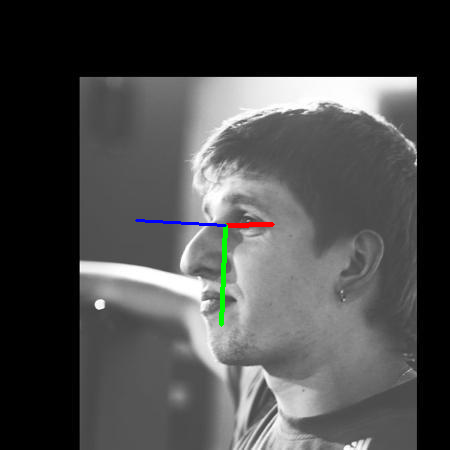

################Predicted by model################


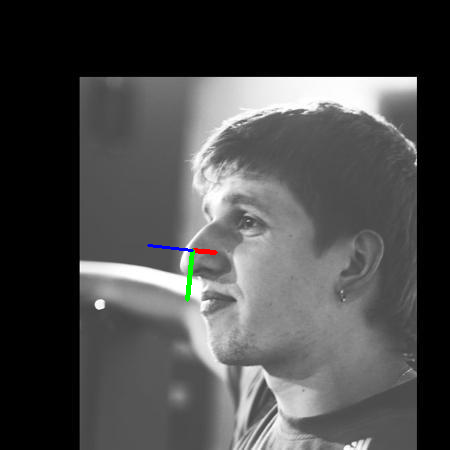

In [ ]:
# Testing the model with known image
random_file = all_images[13]
image = cv2.imread(random_file)
# Read image
mat_file = sio.loadmat(random_file[:-4]+'.mat')
# extracting the labels 3 angels
pose_para = mat_file["Pose_Para"][0][:3]
pitch = pose_para[0]
yaw = pose_para[1]
roll = pose_para[2]
cv2_imshow(draw_axis(image,pitch,yaw,roll))

print('Predicted by model'.center(50,'#'))
# Extract features
image = cv2.imread(random_file)
img = predict_image(image)
# Draw axes
cv2_imshow(img)

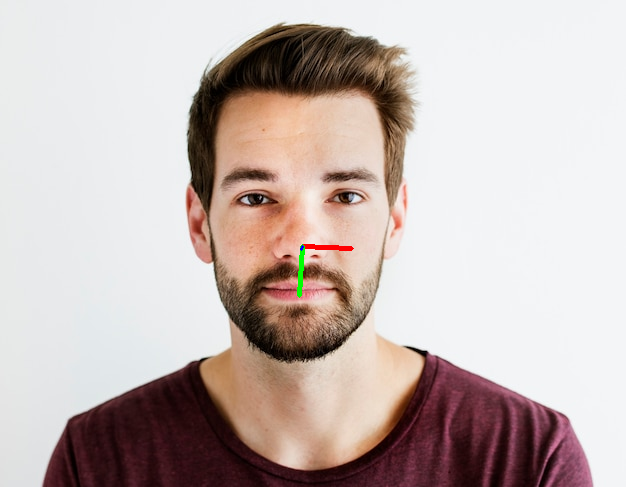

In [ ]:
img_url = 'https://img.freepik.com/free-photo/portrait-white-man-isolated_53876-40306.jpg'

img_file = urlopen(img_url)
arr = np.asarray(bytearray(img_file.read()), dtype=np.uint8)
image = cv2.imdecode(arr,-1)

img = predict_image(image)
# Draw axes
cv2_imshow(img)

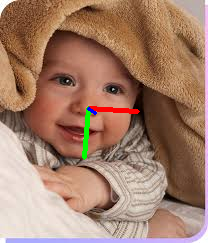

In [ ]:
img_url = 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTvU5n3lnU74Qvf4G4c0timsJOeL7lqBA9L6g&usqp=CAU'

img_file = urlopen(img_url)
arr = np.asarray(bytearray(img_file.read()), dtype=np.uint8)
image = cv2.imdecode(arr,-1)

img = predict_image(image)
# Draw axes
cv2_imshow(img)


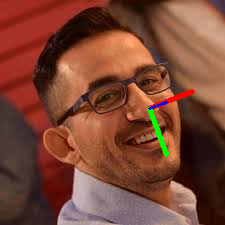

In [ ]:
img_url = 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcR5El21KVDNztewkcvTk4yKRFkktyc1s92DPw&usqp=CAU'

img_file = urlopen(img_url)
arr = np.asarray(bytearray(img_file.read()), dtype=np.uint8)
image = cv2.imdecode(arr,-1)

img = predict_image(image)
# Draw axes
cv2_imshow(img)

In [ ]:
def predict_video(video):
    """Function to take a video path and run the models on it and save to output_video"""
    output_video = 'Out_'+video
    cap = cv2.VideoCapture(video)
    frame_rate = cap.get(cv2.CAP_PROP_FPS)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_video, fourcc, frame_rate, (width, height))

    while True:
            try:
            # Read the next frame from the video
                ret, frame = cap.read()
                if not ret:
                    break
                frame = cv2.flip(frame,1)
                # Run my model
                frame = predict_image(frame)
                # cv2_imshow(frame)
                out.write(frame)
            except Exception as error:
                print(error)
            
            

    cap.release()
    out.release()

def predict_gif(gif,size=50):
    """
    Function to take a gif path and run the models on it and save to output_gif
    """
    output_gif = 'Out_'+gif
    cap = cv2.VideoCapture(gif)
    frame_rate = cap.get(cv2.CAP_PROP_FPS)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    frames = []    
    while True:
            try:
            # Read the next frame from the video
                ret, frame = cap.read()
                if not ret:
                    break
                #frame = cv2.flip(frame,1)
                # Run my model
                frame = predict_image(frame,size)
                # cv2_imshow(frame)
                frames.append(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            except Exception as error:
                print(error)
            
            

    cap.release()
    imageio.mimsave(output_gif, frames)

In [ ]:
predict_gif('kevin-hart-stare.gif')

In [ ]:
predict_gif('slap.gif',size=50)